In [63]:
import os
import os.path as osp

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

import utils

# Prepare the ModelNet40 dataset

In [64]:
from scipy.stats import binned_statistic_2d

class ModelNet40(Dataset):
    def __init__(self,
        root: str, split: str,
        image_shape: tuple = (32, 32),
        proj_axes: list = [[0, 0, 1]]
    ):
        super().__init__()
        assert isinstance(image_shape, tuple) and len(image_shape) == 2, \
            "wrong image shape"

        assert osp.exists(root), \
            "invalid root for modelnet40 dataset"

        shape_names_file = osp.join(root, "modelnet40_shape_names.txt")
        assert osp.exists(shape_names_file), \
            "couldn't find shape-names txt file"
        with open(shape_names_file, 'r') as f:
            shape_names = sorted([line.strip() for line in f.readlines()])
            self.cls2idx = {v:i for i, v in enumerate(shape_names)}
            self.idx2cls = {i:v for i, v in enumerate(shape_names)}

        split_file = osp.join(root, f"modelnet40_{split}.txt")
        assert osp.exists(split_file), \
            "split file not exists"
        
        sample_names = []
        with open(split_file, 'r') as f:
            sample_names = sorted([line.strip() for line in f.readlines()])


        self.data = []
        for obj_name in sample_names:
            cls_name = obj_name.rsplit("_", 1)[0]
            self.data.append((osp.join(root, cls_name, f"{obj_name}.txt"), self.cls2idx[cls_name]))
        
        self.proj_axes = proj_axes
        self.image_shape = image_shape
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        file, gdth = self.data[index]
        points = np.loadtxt(file, delimiter=',')
        fmap = self.project_list(points, self.image_shape)
        return fmap, gdth
    
    def add_proj_dir(self, axis: np.ndarray):
        if not isinstance(axis, np.ndarray):
            axis = np.array(axis)
        assert len(axis.shape) == 1 and len(dir) == 3, "wrong projection axis shape"
        self.proj_axes.append(axis)

    def project_list(self, points: np.ndarray, image_shape: tuple):
        image_list = []
        for axis in self.proj_axes:
            image_list.append(self.project(points, axis, image_shape))
        return np.array(image_list)


    def project(self, points: np.ndarray, axis: np.ndarray, image_shape: tuple):
        assert len(points.shape) == 2 and points.shape[1] >= 3, "wrong 3d coordinate shape"
        coords = np.copy(points[:, :3])
        # move to center and scaled to [-1, +1]
        coords = coords - coords.mean(axis=0)
        coords = coords / np.max(np.sqrt(np.sum(coords**2, axis=1)))

        R = utils.A2B_R(axis, [0, 0, 1])
        coords = (R @ coords.T).T

        x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
        # from [-1, +1] to [0, H/W - 1]
        x = ((x + 1.0) / 2.0 * (image_shape[0] - 1)).astype(np.int32)
        y = ((y + 1.0) / 2.0 * (image_shape[1] - 1)).astype(np.int32)

        image = np.full((*image_shape, points.shape[-1] + 1), 0.0, dtype=np.float32)
        z_buf = np.full(image_shape, -np.inf)

        for r, c, d, point in zip(x, y, z, points):
            if d > z_buf[r][c]:
                z_buf[r][c] = d
                image[r][c] = np.array([*point, d])
        
        return np.transpose(image) # move channel axis to the first

In [65]:
image_shape = (32, 32)
patch_shape = (8, 8)
proj_axes = [
    [int((int(x) - 0.5) * 2) for x in list(bin(i)[2:].zfill(3))] for i in range(2**3)
]

(8, 7, 32, 32)


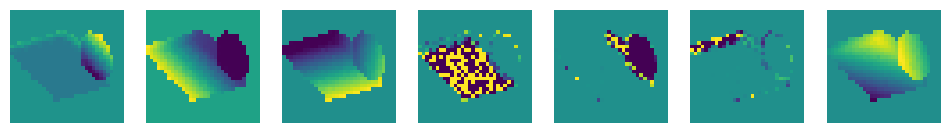

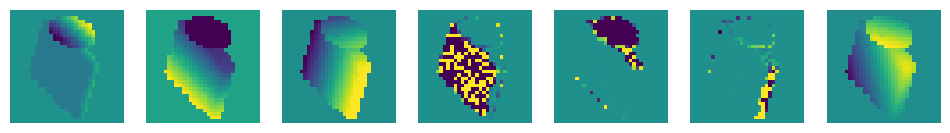

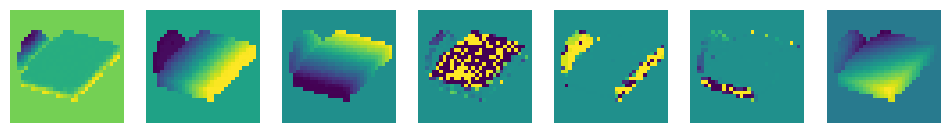

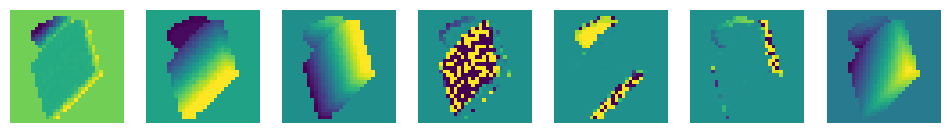

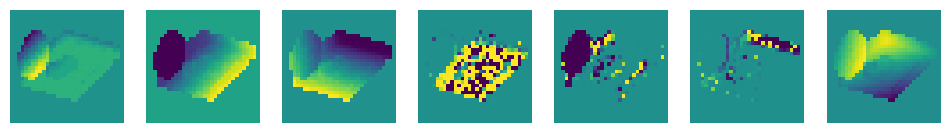

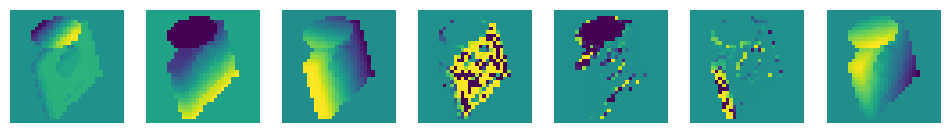

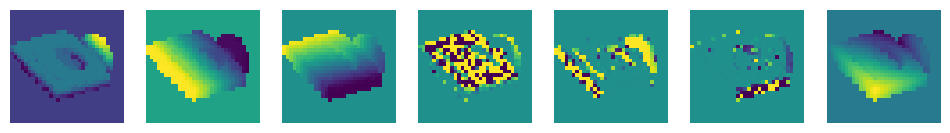

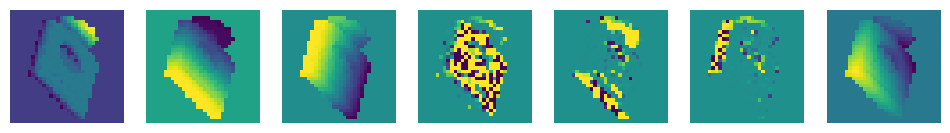

In [66]:
train_dataset = ModelNet40("./data/modelnet40", split="train", image_shape=image_shape, proj_axes=proj_axes)
# 定义训练集和验证集的大小
train_size = int(0.8 * len(train_dataset))  # 80% 用于训练
valid_size = len(train_dataset) - train_size  # 20% 用于验证

# 使用 random_split 进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

for iter, (fmap, gdth) in enumerate(train_dataset):
    print(fmap.shape)
    for view in fmap:
        fig, axes = plt.subplots(1, 7, figsize=(12, 3))
        for ax, chnl in zip(axes, view):
            ax.axis("off")
            ax.imshow(chnl)
        plt.show()
    break

In [67]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self,
        patch_shape: tuple,
        in_channels: int,
        out_channels: int
    ):
        super().__init__()
        assert isinstance(patch_shape, tuple) \
            and len(patch_shape) == 2, f"wrong shape type {patch_shape}"

        self.conv_proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=patch_shape,
            stride=patch_shape
        )
    
    def forward(self, x: torch.Tensor):
        # [B, C, H, W] x
        # [B, E, H, W] projected
        # [B, E, S] S for number of patch embeddings
        # [B, S, E] E for number of feature channel of one embedding
        x = self.conv_proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Embedding(nn.Module):
    def __init__(self,
        num_images: int,
        image_shape: tuple,
        patch_shape: tuple,
        in_channels: int,
        out_channels: int
    ):
        super().__init__()

        assert isinstance(image_shape, tuple) \
            and len(image_shape) == 2, f"wrong shape type {image_shape}"

        self.patch_embedding = PatchEmbedding(
            patch_shape,
            in_channels,
            out_channels
        )

        image_shape = (
            round(image_shape[0] / patch_shape[0]) * patch_shape[0],
            round(image_shape[1] / patch_shape[1]) * patch_shape[1]
        )
        self.image_shape = image_shape
        self.patch_shape = patch_shape
        
        # additional token put on head
        num_patches = (image_shape[0] // patch_shape[0]) * (image_shape[1] // patch_shape[1])
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, out_channels)
        )
        # add on all token
        self.pos_encod = nn.Parameter(
            torch.randn(1, num_patches * num_images + 1, out_channels)
        )
    
    def forward(self, x: torch.Tensor):
        B, I, C, H, W = x.size()
        x = x.view(B * I, C, H, W)
        x =  F.interpolate(x, self.image_shape, mode="bilinear", align_corners=False)
        x = self.patch_embedding(x)
        _, S, E = x.size()
        x = x.view(B, I, S, E)
        x = x.reshape(B, I * S, E)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1) # add cls_token to first place of each sequence
        x = x + self.pos_encod # add on positional encoding to every element
        x = F.dropout(x, p=1e-2)

        return x

# test
embedding = Embedding(num_images=8, image_shape=image_shape, patch_shape=patch_shape, in_channels=7, out_channels=64)
for fmap, gdth in train_dataloader:
    token = embedding(fmap)
    print(token.size())
    break

torch.Size([4, 129, 64])


In [68]:
import torch

a = 6

# 每个样本包含 8 张特征图，特征图三通道 4x4 大小
x = torch.arange(8 * 3 * 4 * 4).to(torch.float32) + 1

# 将其 reshape 成 4x4 的二维张量
x = x.reshape(1, 8, 3, 4, 4)
B, I, C, H, W = x.size()
print(x.size(), "\n", x)
x = x.view(B* I, C, H, W)
x = F.max_pool2d(x, (2, 2))
print(x.size(), "\n", x)
x = x.flatten(2)
print(x.size(), "\n", x)
x = x.transpose(1, 2)
print(x.size(), "\n", x)


torch.Size([1, 8, 3, 4, 4]) 
 tensor([[[[[  1.,   2.,   3.,   4.],
           [  5.,   6.,   7.,   8.],
           [  9.,  10.,  11.,  12.],
           [ 13.,  14.,  15.,  16.]],

          [[ 17.,  18.,  19.,  20.],
           [ 21.,  22.,  23.,  24.],
           [ 25.,  26.,  27.,  28.],
           [ 29.,  30.,  31.,  32.]],

          [[ 33.,  34.,  35.,  36.],
           [ 37.,  38.,  39.,  40.],
           [ 41.,  42.,  43.,  44.],
           [ 45.,  46.,  47.,  48.]]],


         [[[ 49.,  50.,  51.,  52.],
           [ 53.,  54.,  55.,  56.],
           [ 57.,  58.,  59.,  60.],
           [ 61.,  62.,  63.,  64.]],

          [[ 65.,  66.,  67.,  68.],
           [ 69.,  70.,  71.,  72.],
           [ 73.,  74.,  75.,  76.],
           [ 77.,  78.,  79.,  80.]],

          [[ 81.,  82.,  83.,  84.],
           [ 85.,  86.,  87.,  88.],
           [ 89.,  90.,  91.,  92.],
           [ 93.,  94.,  95.,  96.]]],


         [[[ 97.,  98.,  99., 100.],
           [101., 102., 103.,